In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set()

""" 
DSC672
Team: John Matune, Mike Yacobucci, Steve Rummel
Project: Energy Consumption and Renewable Energy
Purpose: 

Import solar and wind data from the relevant source files, 
convert string-format date and time into valid datetime values,
remove unneeded columns, normalize column headers, and
export to canonical data source for further analysis.
"""

solar_prod = pd.read_csv('./raw/solararray_production.csv')
wind_prod = pd.read_csv('./raw/windfarm_production.csv')

solar_prod.rename(index=str, columns={"Electricity_KW_HR": "KWH"}, inplace=True)
solar_prod['Source'] = 'Solar'
wind_prod.rename(index=str, columns={"Electricity_KW_HR": "KWH"}, inplace=True)
wind_prod['Source'] = 'Wind'

power_production = pd.concat([solar_prod, wind_prod], ignore_index=True, sort=False)
power_production['Date'] = pd.to_datetime(power_production['Date'])
power_production['Time'] =  power_production['Date'] + pd.to_timedelta(power_production['Hour'], unit='h')

power_production.set_index('Date', inplace=True)


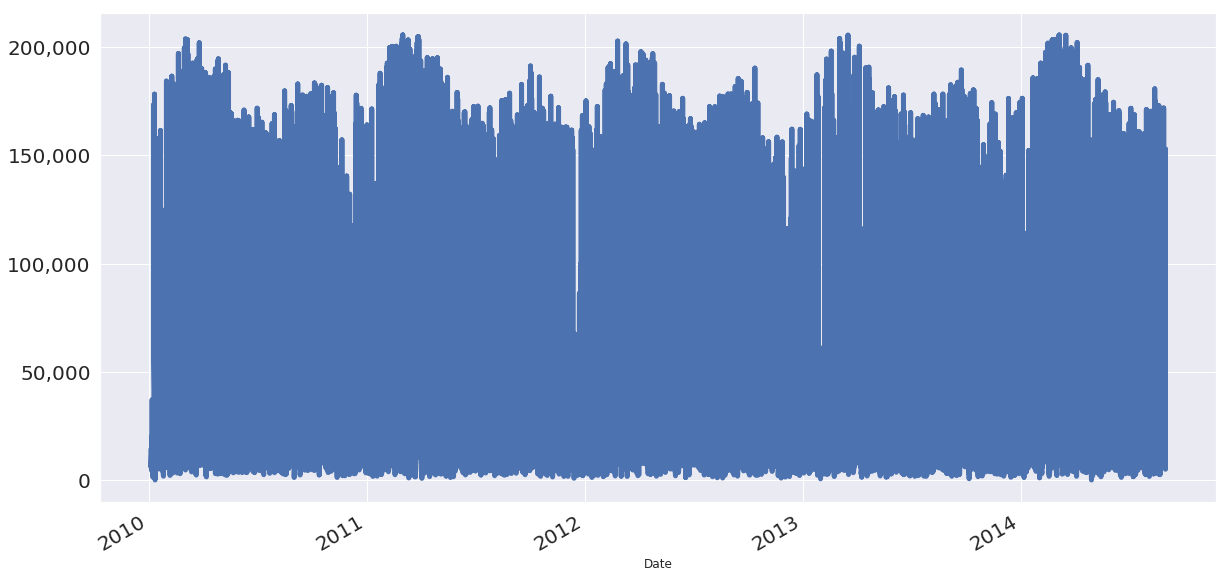

In [2]:
power_production['KWH'].loc[power_production['Source'] == 'Solar'].plot(figsize=(20,10), linewidth=5, fontsize=20).yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

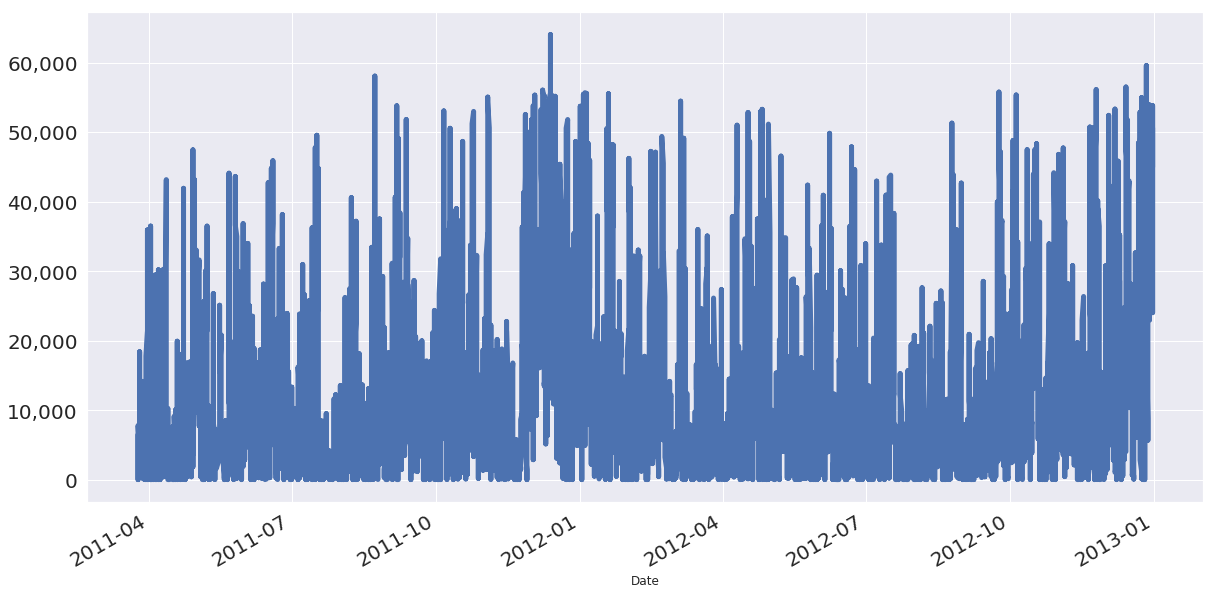

In [3]:
power_production['KWH'].loc[power_production['Source'] == 'Wind'].plot(figsize=(20,10), linewidth=5, fontsize=20).yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

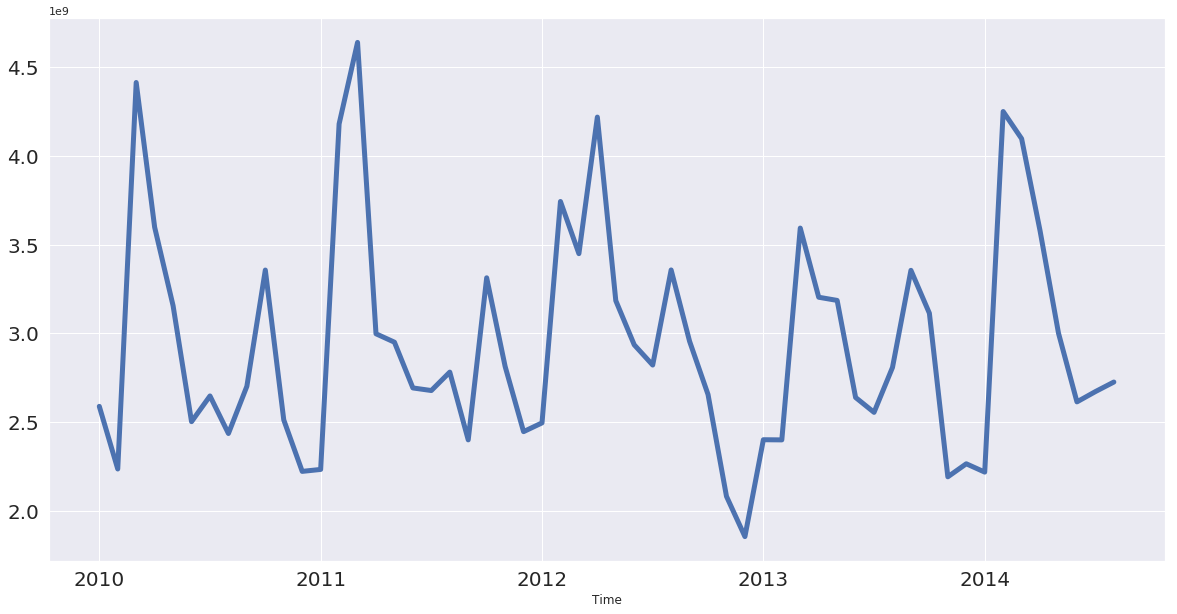

In [4]:
# Solar and Wind only overlap for ~2 years (2011-2012), so may need to exclude some data where we do not have data, 
# assuming our analysis will require both solar and wind to be available to replace nonrenewable sources.
# Hypothesis: Solar power varies sufficiently little over the course of years that we can safely exclude most of it 
# and consider 2012 as representative. Alternatively, use an average of the years we do have.
# Note: Solar readings were not taken from 6 pm through 9 am, unsurprisingly.

solar = power_production.loc[power_production['Source'] == 'Solar']
#solar.reset_index(inplace=True)
solar.set_index('Time', inplace=True)
#print(solar.head())
#print(solar.info())
solvar = solar.resample('M').var()
solvar['KWH'].plot(figsize=(20,10), linewidth=5, fontsize=20);

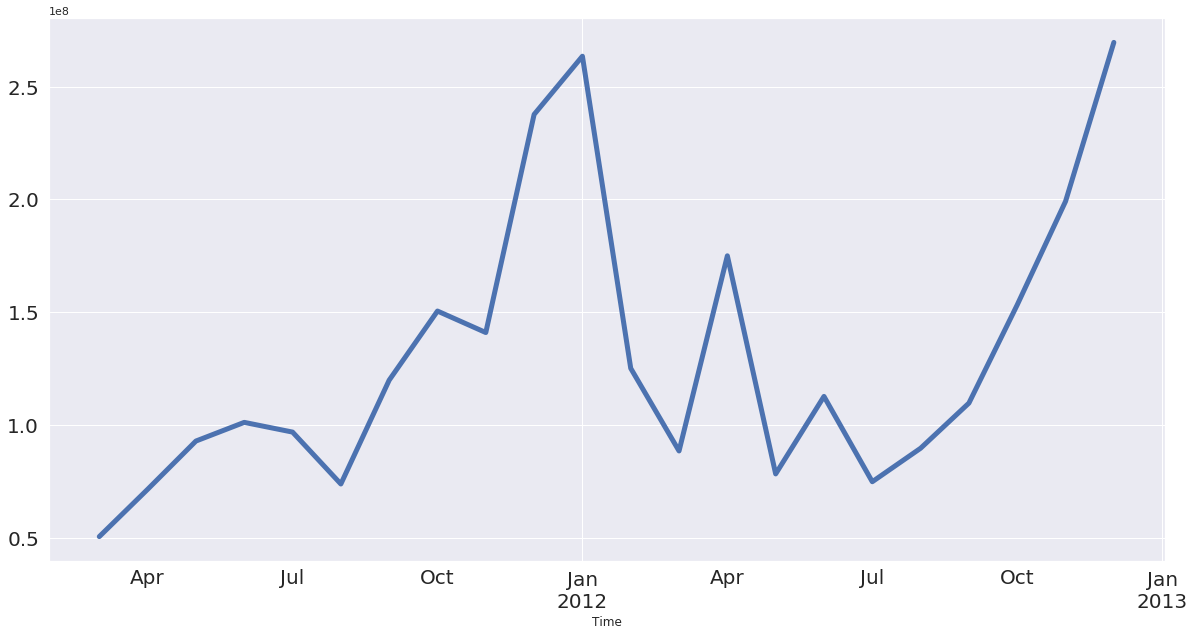

In [5]:
# Solar and Wind only overlap for ~2 years (2011-2012), so may need to exclude some data where we do not have data, 
# assuming our analysis will require both solar and wind to be available to replace nonrenewable sources.
# Hypothesis: Solar power varies sufficiently little over the course of years that we can safely exclude most of it 
# and consider 2012 as representative. Alternatively, use an average of the years we do have.
# Note: Solar readings were not taken from 6 pm through 9 am, unsurprisingly.

wind = power_production.loc[power_production['Source'] == 'Wind']
wind.set_index('Time', inplace=True)
windvar = wind.resample('M').var()
windvar['KWH'].plot(figsize=(20,10), linewidth=5, fontsize=20);

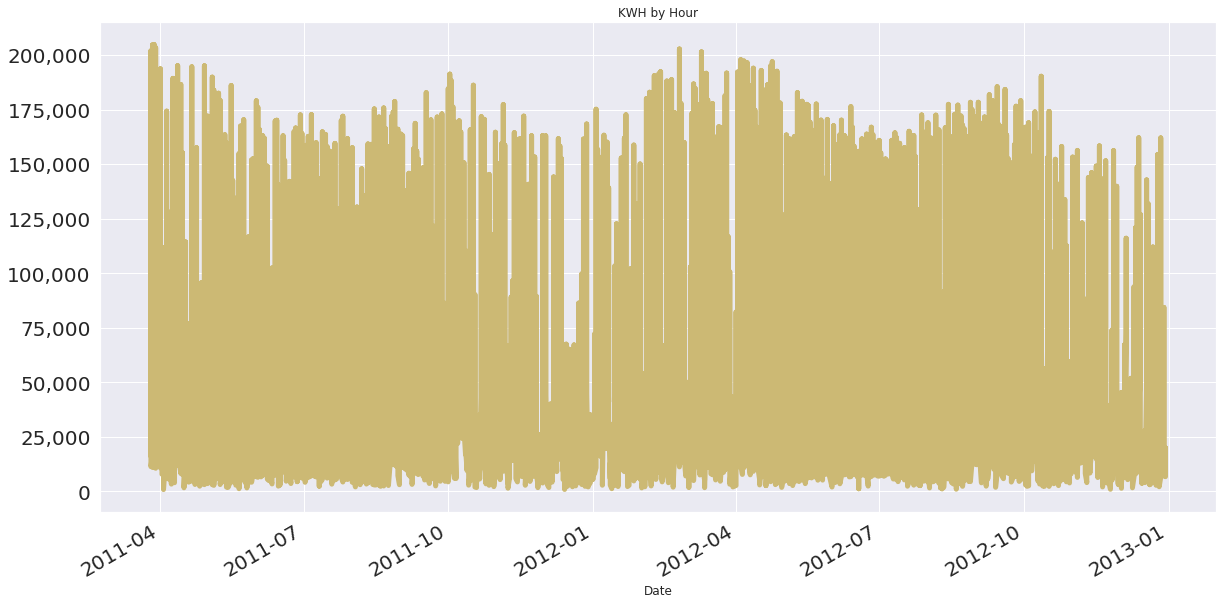

In [6]:
# Get the date period in which we have both solar and wind values.
# The maximum 'start' date and the minimum 'end' date.

solar.reset_index(inplace=True)
solar.set_index('Hour', inplace=True)
wind.reset_index(inplace=True)
wind.set_index('Hour', inplace=True)

solmin = solar.min()
solmax = solar.max()
windmin = wind.min()
windmax = wind.max()
mindate = max(solmin['Time'], windmin['Time'])
maxdate = min(solmax['Time'], windmax['Time'])

# Subset our original power_production dataset to only include those dates.
power_prod_common_timeframe = power_production.loc[(power_production.index > mindate) & (power_production.index < maxdate)]

power_prod_common_timeframe['KWH'].loc[power_prod_common_timeframe['Source'] == 'Solar'].plot(figsize=(20,10),
                                                                                              linewidth=5,
                                                                                              title='KWH by Hour',
                                                                                              fontsize=20,
                                                                                              color='y').yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));


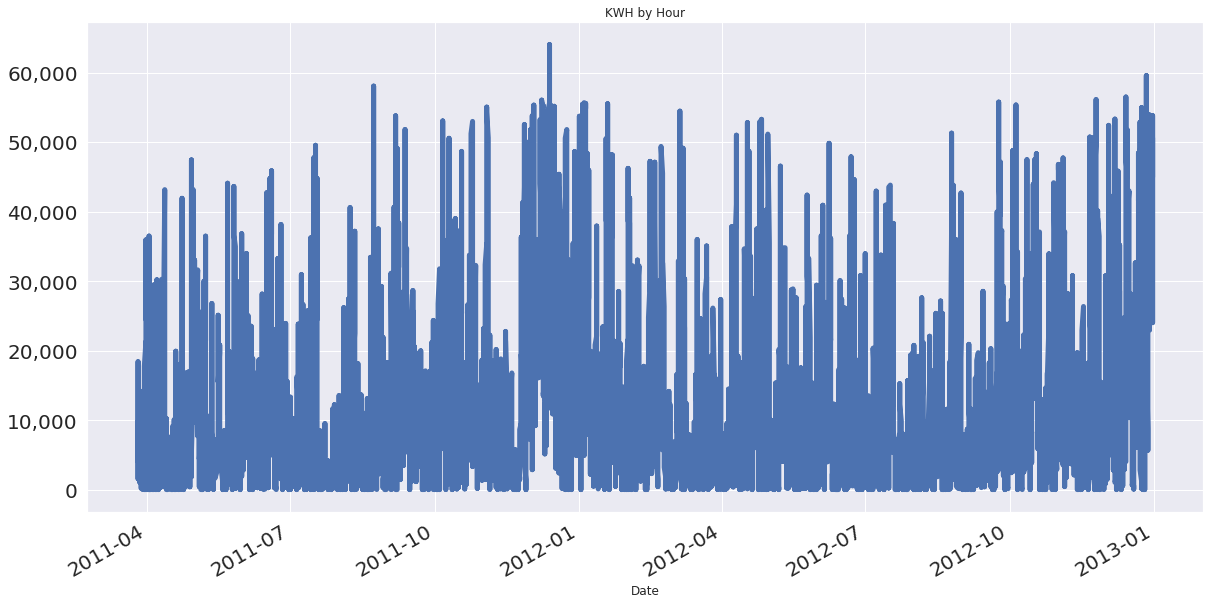

In [7]:
power_prod_common_timeframe['KWH'].loc[power_prod_common_timeframe['Source'] == 'Wind'].plot(figsize=(20,10),
                                                                                              linewidth=5,
                                                                                              title='KWH by Hour',
                                                                                              fontsize=20,
                                                                                              color='b').yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));

In [8]:
solar.reset_index(inplace=True)
solar.set_index('Time', inplace=True)
wind.reset_index(inplace=True)
wind.set_index('Time', inplace=True)

solar_ctf = solar.loc[(solar.index > mindate) & (solar.index < maxdate)]
wind_ctf = wind.loc[(wind.index > mindate) & (wind.index < maxdate)]

# Export production for all dates covered, regardless of source.
sol_all_dte = pd.Series(solar['KWH'], name='Solar')
win_all_dte = pd.Series(wind['KWH'], name='Wind')
all_src_all_dte = pd.concat([sol_all_dte, win_all_dte], axis=1)
all_src_all_dte['Solar'].fillna(0.0, inplace=True)
all_src_all_dte['Wind'].fillna(0.0, inplace=True)
all_src_all_dte.to_pickle("./processed/production_all_src_all_dte.pkl")

# Export production for all dates covered, only if we have solar and wind data.
sol = pd.Series(solar_ctf['KWH'], name='Solar')
win = pd.Series(wind_ctf['KWH'], name='Wind')
all_src = pd.concat([sol, win], axis=1)
all_src['Solar'].fillna(0.0, inplace=True)
all_src['Wind'].fillna(0.0, inplace=True)
all_src.to_pickle("./processed/production_all_src_from_{}_to_{}.pkl".format(mindate, maxdate))


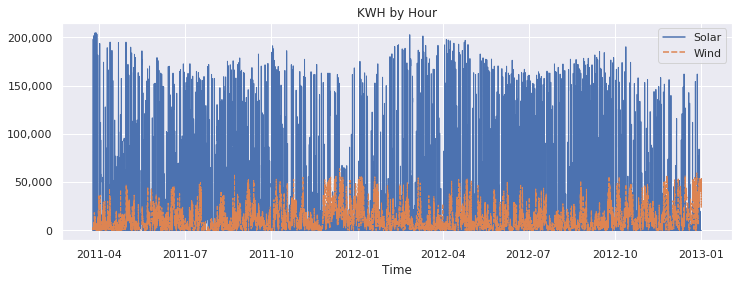

In [9]:
chart_dims = (12, 4)
fig, ax = plt.subplots(figsize=chart_dims)

sns.set()
snplot = sns.lineplot(data=all_src,
                      ax=ax,
                      linewidth=1,
                      );
snplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));
snplot.set_title('KWH by Hour');

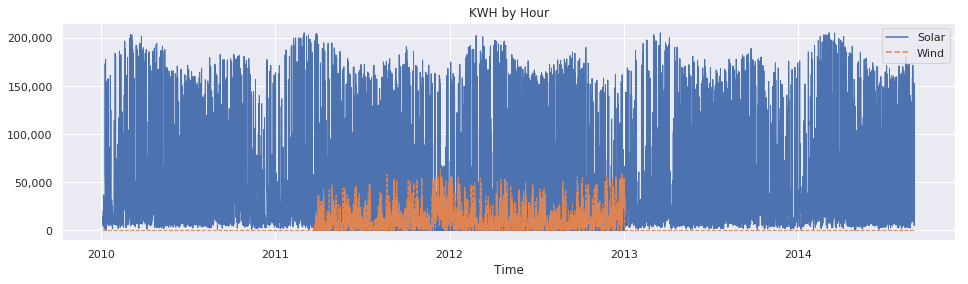

In [10]:
chart_dims = (16, 4)
fig, ax = plt.subplots(figsize=chart_dims)

sns.set()
snplot = sns.lineplot(data=all_src_all_dte,
                      ax=ax,
                      linewidth=1,
                      );
snplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));
snplot.set_title('KWH by Hour');

In [11]:
# Build a dataset of 'everything'

# Add: Windspeed
wind_speed = pd.read_csv('./raw/windfarm_windspeed.csv')
wind_speed.rename(index=str, columns={"Date_time": "Time"}, inplace=True)
wind_speed['Time'] = pd.to_datetime(wind_speed['Time'], format='%d%b%y:%H:%M:%S')
wind_speed.drop(['Hour'], axis=1, inplace=True)
wind_speed.drop(['Location'], axis=1, inplace=True)
wind_speed.set_index('Time', inplace=True)

all_src_all_dte.rename(index=str, columns={"Wind": "Wind_KWH"}, inplace=True)
all_src_all_dte.rename(index=str, columns={"Solar": "Solar_KWH"}, inplace=True)
all_src_all_dte = pd.concat([all_src_all_dte, wind_speed], axis=1)
all_src_all_dte['Wind_Speed'].fillna(0.0, inplace=True)



In [12]:
# Add: Solar Angle
s_angle = pd.read_csv('./raw/solararray_solarangle.csv')
#s_angle['Date'] = pd.to_datetime(s_angle['Date'])

for field in list(s_angle):
    s_angle[field].fillna(0.0, inplace=True)
    s_angle[field] = s_angle[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
s_angle['Month'] = s_angle['Month'].apply('{:0>2}'.format)
s_angle['Day'] = s_angle['Day'].apply('{:0>2}'.format)
s_angle['Hour'] = s_angle['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
s_angle['Time'] = s_angle[['Year', 'Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

# Cast the string to a datetime object.
# Note: Adding the hour at the end kept erroring out, so did it the brute
# force way by adding it after as a timedelta.
s_angle['Time'] = pd.to_datetime(s_angle['Time'], format='%Y:%m:%d')
s_angle['Time'] +=  pd.to_timedelta(s_angle['Hour'].astype(int), unit='h')

# Get rid of columns we do not need.
drop_these = ['Year', 'Month', 'Day', 'Hour', 'Location']
for field in drop_these:
    s_angle.drop([field], axis=1, inplace=True)
    
s_angle.set_index('Time', inplace=True)

all_src_all_dte = all_src_all_dte.join(s_angle, how='left', sort=False)

In [13]:
# Add Weather

weather = pd.read_csv('./raw/solararray_weather.csv')

for field in list(weather):
    weather[field].fillna(0.0, inplace=True)
    weather[field] = weather[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
weather['Month'] = weather['Month'].apply('{:0>2}'.format)
weather['Day'] = weather['Day'].apply('{:0>2}'.format)
weather['Hour'] = weather['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
weather['Time'] = weather[['Year', 'Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

weather['Time'] = pd.to_datetime(weather['Time'], format='%Y:%m:%d')
weather['Time'] +=  pd.to_timedelta(weather['Hour'].astype(int), unit='h')
weather.set_index('Time', inplace=True)

drop_these = ['Year', 'Month', 'Day', 'Hour', 'Location']
for field in drop_these:
    weather.drop([field], axis=1, inplace=True)

all_src_all_dte = all_src_all_dte.join(weather, how='left', lsuffix='_AT_WINDFARM', rsuffix='_AT_SOLARRAY', sort=False)

for field in list(all_src_all_dte):
    all_src_all_dte[field].fillna(0.0, inplace=True)
    all_src_all_dte[field] = pd.to_numeric(all_src_all_dte[field])

print(all_src_all_dte.head())
print(all_src_all_dte.dtypes)

                     Solar_KWH  Wind_KWH  Wind_Speed_AT_WINDFARM  \
Time                                                               
2011-03-24 19:00:00        0.0       0.0                     4.7   
2011-03-24 20:00:00        0.0       0.0                     5.3   
2011-03-24 21:00:00        0.0       0.0                     6.4   
2011-03-24 22:00:00        0.0       0.0                     6.1   
2011-03-24 23:00:00        0.0       0.0                     5.5   

                     Solar_Elevation  Cloud_Cover_Fraction  Dew_Point  \
Time                                                                    
2011-03-24 19:00:00        19.498113                   0.0      -12.8   
2011-03-24 20:00:00         8.891553                   0.0      -11.7   
2011-03-24 21:00:00        -1.942140                   0.0      -11.7   
2011-03-24 22:00:00       -12.634295                   0.0      -12.8   
2011-03-24 23:00:00       -22.788566                   0.0      -13.9   

           

In [14]:
all_src_all_dte.to_pickle("./processed/production_all_dates_and_variables.pkl")

In [20]:
fields = [['Solar_KWH'],
          ['Wind_KWH'],
          ['Wind_Speed_AT_WINDFARM'],
          ['Solar_Elevation'], 
          ['Cloud_Cover_Fraction'],
          ['Dew_Point'], 
          ['Humidity_Fraction'],
          ['Precipitation'],
          ['Pressure'], 
          ['Temperature'], 
          ['Visibility']
         ]

In [24]:
for field in fields:
    print("{}: \n{}".format(field[0], all_src_all_dte[field].describe()))

Solar_KWH: 
           Solar_KWH
count   42403.000000
mean    30287.777289
std     50272.779485
min         0.000000
25%         0.000000
50%         0.000000
75%     41355.200000
max    205619.360000
Wind_KWH: 
           Wind_KWH
count  42403.000000
mean    4370.381435
std     9501.835678
min        0.000000
25%        0.000000
50%        0.000000
75%     3516.000000
max    64032.000000
Wind_Speed_AT_WINDFARM: 
       Wind_Speed_AT_WINDFARM
count            42403.000000
mean                 2.104674
std                  3.174603
min                  0.000000
25%                  0.000000
50%                  0.000000
75%                  4.400000
max                 19.800000
Solar_Elevation: 
       Solar_Elevation
count     42403.000000
mean          0.592603
std          20.687065
min         -69.227891
25%           0.000000
50%           0.000000
75%           0.000000
max          69.359154
Cloud_Cover_Fraction: 
       Cloud_Cover_Fraction
count          42403.000000
mean     

In [19]:
# Print out some nice charts of our variables.
for field in fields:
    print("Plotting {}...".format(field[0]))
    chart_dims = (16, 4)
    fig, ax = plt.subplots(figsize=chart_dims)
    sns.set()
    snplot = sns.lineplot(data=all_src_all_dte[field[0]],
                          ax=ax,
                          linewidth=1,
                          );
    snplot.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'));
    snplot.set_title(field[0]);
    print("Saving {}...".format(field[0]))
    #snplot.savefig("{}.png".format(field[0]));
    exp = snplot.get_figure()
    exp.savefig("./Images/{}.png".format(field[0]))
    fig.clf()
    exp.clf()

Plotting Solar_KWH...
Saving Solar_KWH...
Plotting Wind_KWH...
Saving Wind_KWH...
Plotting Wind_Speed_AT_WINDFARM...
Saving Wind_Speed_AT_WINDFARM...
Plotting Solar_Elevation...
Saving Solar_Elevation...
Plotting Cloud_Cover_Fraction...
Saving Cloud_Cover_Fraction...
Plotting Dew_Point...
Saving Dew_Point...
Plotting Humidity_Fraction...
Saving Humidity_Fraction...
Plotting Precipitation...
Saving Precipitation...
Plotting Pressure...
Saving Pressure...
Plotting Temperature...
Saving Temperature...
Plotting Visibility...
Saving Visibility...


<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>

<Figure size 1152x288 with 0 Axes>